In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import itertools
import os

from keras.utils.np_utils import to_categorical 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras.optimizers import RMSprop,Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from keras.utils.np_utils import to_categorical 

from sklearn.model_selection import train_test_split

### Data Preparation

In [5]:
# load the data
data = (r'C:/Users/almag/Desktop/CS156/braintumor/Training')
classes = ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
for i in classes:
    path = os.path.join(data, i)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img))  

In [8]:
# preprocessing the data

train_data = []

imsize = 128
image_array = cv2.resize(img_array, (imsize, imsize))

for i in classes:
    train_path = os.path.join(data,i)
    tag = classes.index(i)    
    for img in os.listdir(train_path):
        image_arr = cv2.imread(os.path.join(train_path , img), cv2.IMREAD_GRAYSCALE)
        new_image_array = cv2.resize(image_arr, (imsize,imsize))
        train_data.append([new_image_array , tag])


In [10]:
# feature selection

X = []
Y = []

for i,j in train_data:
    X.append(i)
    Y.append(j)
    
X = np.array(X).reshape(-1,imsize,imsize)
X = X/255.0  
X = X.reshape(-1,128,128,1)

# encode y
y_encoded = to_categorical(Y, num_classes = 4)

In [11]:
# test set: 10%
X_train , X_test, y_train, y_test = train_test_split(X, 
                                                     y_encoded ,
                                                     test_size = 0.1,
                                                     random_state = 42)
# validation set: 10%
X_train , X_val, y_train, y_val = train_test_split(X_train, 
                                                   y_train, 
                                                   test_size = 0.1, 
                                                   random_state = 42)


### The model

In [12]:
# initiate the model
nn = Sequential()

In [13]:
# adding layers

nn.add(Conv2D(filters = 128, kernel_size = (3,3),padding = 'Same', activation ='softmax'))
nn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
nn.add(Dropout(0.2))

nn.add(Conv2D(filters = 256, kernel_size = (2,2),padding = 'Same', activation ='relu'))
nn.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
nn.add(Dropout(0.2))

nn.add(Flatten())

nn.add(Dense(1024, activation = "relu"))
nn.add(Dropout(0.5))

nn.add(Dense(4, activation = "softmax"))

In [19]:
### PARAMETER CHOICES ###

# optimizer: Adam because it combines good properties of Adadelta and RMSprop
# loss: categorical_crossentropy' is most efficient for categorical classification
# metrics: we need to report test error rates, which is 1-accuracy

nn.compile(optimizer = 'Adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

epochs = 5
batch_size = 32

# augment the images

imagegen = ImageDataGenerator(
        horizontal_flip=True,
        zca_whitening=False, 
        width_shift_range=0,  
        height_shift_range=0,  
        vertical_flip=False)

In [20]:
imagegen.fit(X_train)
history = nn.fit(imagegen.flow(X_train,y_train,batch_size = batch_size),
                              epochs = epochs, validation_data = (X_val,y_val))   

Epoch 1/5
73/73 [==============================] - 231s 3s/step - loss: 1.2478 - accuracy: 0.4563 - val_loss: 1.0988 - val_accuracy: 0.5367
Epoch 2/5
73/73 [==============================] - 238s 3s/step - loss: 1.0803 - accuracy: 0.5274 - val_loss: 0.9872 - val_accuracy: 0.5676
Epoch 3/5
73/73 [==============================] - 239s 3s/step - loss: 0.9762 - accuracy: 0.5889 - val_loss: 0.9214 - val_accuracy: 0.6023
Epoch 4/5
73/73 [==============================] - 239s 3s/step - loss: 0.9407 - accuracy: 0.6112 - val_loss: 0.8955 - val_accuracy: 0.6332
Epoch 5/5
73/73 [==============================] - 236s 3s/step - loss: 0.9083 - accuracy: 0.6373 - val_loss: 0.8620 - val_accuracy: 0.6525


### The accuracy

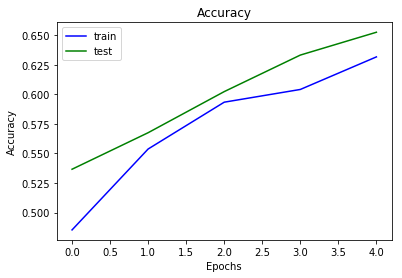

In [21]:
plt.plot(history.history["accuracy"],c = "blue")
plt.plot(history.history["val_accuracy"],c = "green")
plt.title("Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.rcParams["figure.figsize"] = (50,50)
plt.legend(["train", "test"])

# Accuracy of Test Dataset

In [22]:
score = nn.evaluate(X_test, y_test, verbose = 0)
score[1]

0.6202090382575989